# NYC Capital Projects

## Notebook 09: Generate Decision Tree Prediction Models 

This notebook explores the use of decision tree models to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` as a non-parametric alternative to the linear and smoothing spline models employed in prior notebooks. First, decision tree classifiers are investigated to determine how well a decision tree model can perform to predict simple binary over- and under-budget/schedule outcomes. Next, decision tree regressors are investigated to generate continuous predictions for `Budget_Change_Ratio` and `Schedule_Change_Ratio`. For these models, all data features are considered potential predictors in our models, and we combinatorically explore all feature combinations to identify the best features for use in these models. Unlike our previous linear and smoothing spline models, because these models are non-parametric, we found that scaling of our quantitative predictors was not necessary to generate improved predictive results.

### Project authors

- [An Hoang](https://github.com/hoangthienan95)
- [Mark McDonald](https://github.com/mcdomx)
- [Mike Sedelmeyer](https://github.com/sedelmeyer)

### Inputs:

The following files are required to successfully run this notebook.

- ``../data/processed/NYC_capital_projects_3yr_final_train.csv``

    The final training dataset, including all engineered features, for use in prediction models.


- ``../data/processed/NYC_capital_projects_3yr_final_test.csv``

    The final test dataset, including all engineered features, for use in prediction models.

### Outputs:

No files are generated during execution of this notebook.

# Notebook contents

1. [Import libraries and load data](#Import-libraries-and-load-data)

2. [Select attributes X and target values y](#Select-attributes-X-and-target-values-y)

3. [Define functions for calculating model performance and plotting results](#Define-functions-for-calculating-model-performance-and-plotting-results)

4. [Fit decision tree classification models with various attribute combinations](#Fit-decision-tree-classification-models-with-various-attribute-combinations)

5. [Fit decision tree regression models with various attribute combinations](#Fit-decision-tree-regression-models-with-various-attribute-combinations)

# Import libraries and load data

[Return to top](#Notebook-contents)

In [1]:
from datetime import datetime, timedelta
import itertools
import logging
import math
import os
import pickle
import sys
import warnings

import graphviz
# from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as sm

from caproj.scale import *
from caproj.model import *
from caproj.visualize import *
from caproj.datagen import generate_interval_data

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphcis
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# display(HTML("<style>.container {width:95% !important;}</style>"))

In [4]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [5]:
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

# Select attributes X and target values y

[Return to top](#Notebook-contents)

In [6]:
# All possible (reasonable) Attributes
X_cols_all = [
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Budget_Start',
    'Duration_Start'
]

# includes +/- values of total change
y_cols_change = [
    'Budget_Change',
    'Schedule_Change'
]

# final budget amount and duration
y_cols_end_value = [
    'Budget_End',
    'Duration_End'
]

# includes +/- values of relative change
y_cols_ratio = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

categories = ['Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']


# Define functions for calculating model performance and plotting results

[Return to top](#Notebook-contents)

In [7]:
# Calculate train and test scores for model inputs and outputs

depths = list(range(1, 21))
cv = 5

def calc_meanstd_logistic(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeClassifier(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy' )))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='accuracy' )))

        models.append(model)
        
        # use AUC scoring
        train_scores.append( roc_auc_score(y_tr, model.predict(X_tr)))
        test_scores.append(  roc_auc_score(y_te, model.predict(X_te)))
 
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

def calc_meanstd_regression(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        model = DecisionTreeRegressor(max_depth=d, random_state=109)
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='r2')))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='r2')))

        models.append(model)
        
        # use R2 scoring
        train_scores.append( model.score(X_tr, y_tr) )  # append train score - picks accuracy or r2 automatically
        test_scores.append(  model.score(X_te, y_te) ) # append cv test score - picks accuracy or r2 automatically
       
    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    
    return cvmeans, cvstds, train_scores, test_scores, models

# Return x and y data for train and test sets
def define_train_and_test(data_train, data_test, attributes, response, logistic) -> (pd.DataFrame, pd.DataFrame):
    X_tr = data_train[attributes]
    y_tr = data_train[response]

    X_te = data_test[attributes]
    y_te = data_test[response]
    
    if logistic:
        y_tr = (y_tr>0)*1
        y_te = (y_te>0)*1
    
    return X_tr, X_te, y_tr, y_te

# helper function to expand attributes when dummies or multuple colmuns are used
def expand_attributes(attrs):

    # update the attributes to use dummies if 'category' is included
    if 'Category' in attrs:
        attrs.remove('Category')
        attrs += categories
       
    if 'umap_attributes_2D_embed' in attrs:
        attrs.remove('umap_attributes_2D_embed')
        attrs += ['umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2']
        
    # ensure that only 1 embedding is selected
    count = 0
    embedding = None
    for i in ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']:
        if i in attrs:
            count += 1
            embedding = i
    if count > 1:
        print("ERROR")
        print("Only one of the three embeddings is allowed.")
        return
    
    if embedding in attrs:
        attrs.remove(embedding)
        attrs += [f'{embedding}_1', f'{embedding}_2']
        
    return attrs

# plot the best depth finder for decision tree model
# relies on 'result' dictionary from 'calculate' function
def plot_me(result):
    
    depths = list(range(1, 21))
    cv = 5
    
    responses = result.get('responses')
    full_attributes = result.get('full_attributes')
    attributes = result.get('attributes')
    score_type = result.get('scoring')
    model_type = result.get('model_type')
    train_scores = result.get('train_scores')
    test_scores = result.get('test_scores')
    x = result.get('depths')
    
    print(f"Model Optmized for: {result.get('responses')}")
    
    fig, ax = plt.subplots(ncols = len(responses), figsize=(15,6))
    
    for i, (a, response) in enumerate(zip(np.ravel(ax), responses)):

        best_depth = result.get('best_depth')
        best_score = test_scores[best_depth-1]

        a.set_xlabel("Maximum Tree Depth")

        attrs_title = '\n'.join(attributes)
        title = f"Model: {model_type}\nResp: {response}\nAttrs: {attrs_title}"

        a.set_title(f"{title}\nBest test {score_type.capitalize()} score: {best_score} at depth {best_depth}", fontsize=10)
        a.set_ylabel(f"{score_type.capitalize()} Score")
        a.set_xticks(depths)

        # Plot model train scores
        a.plot(x, train_scores, 'b-', marker='o', label=f"Model Train {score_type.capitalize()} Score")

        # Plot model test scores
        a.plot(x, test_scores, 'o-', marker='.', label=f"Model Test {score_type.capitalize()} Score")

        if i == len(responses)-1:
            a.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
            
# returns the results of using a set of attributes on the data
def calculate(data_train, data_test, attributes:list, responses_list:list, logistic=True):
    
    if logistic:
        model_type = 'Logistic'
        score_type = 'auc'
        calc = calc_meanstd_logistic
    else:
        model_type = 'Regression'
        score_type = 'r2'
        calc = calc_meanstd_regression
        
    # remove multi-output responses, if not using logistic regression
    responses = [] 
    for r in responses_list:
        if type(r) == str:
            r = [r]
        if len(r) > 1 and not logistic:
            continue
        responses.append(r)
    
    results = []
    model_dict = []
    # update the attributes to use dummies if 'category' is included
    attrs = expand_attributes(attributes.copy())
    
    for i, response in enumerate(responses):

        X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change_Ratio', 'Schedule_Change_Ratio'], logistic=logistic)
        
        cvmeans, cvstds, train_scores, test_scores, models = calc(X_tr, y_tr[response], X_te, y_te[response])

        best_model = models[test_scores.argmax()]
        best_score = test_scores[test_scores.argmax()]
        best_depth = test_scores.argmax()+1
        
        desc = f"{model_type} Tree. Depth: {best_depth}"

        results.append({'desc':desc,
                        'model_type':model_type,
                        'attributes':attributes,
                        'full_attributes':attrs,
                        'responses':response,
                        'Budget_Change_Ratio': 1 if 'Budget_Change_Ratio' in response and len(response) == 1 else 0,
                        'Schedule_Change_Ratio': 1 if 'Schedule_Change_Ratio' in response and len(response) == 1 else 0,
                        'Budget_and_Schedule_Change': 1 if len(response) == 2 else 0,
                        'scoring': score_type,
                        'best_depth':best_depth,
                        'train_score':train_scores[best_depth-1],
                        'train_scores':train_scores,
                        'test_score':test_scores[best_depth-1],
                        'test_scores':test_scores,
                        'best_model':best_model,
                        'depths':depths
                       })
        
        model_dict.append(generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                         model_descr=desc, 
                                         X_train=X_tr, 
                                         X_test=X_te, 
                                         y_train=y_tr, 
                                         y_test=y_te, 
                                         multioutput=logistic,
                                         verbose=False,
                                         predictions=True,
                                         scores=True,
                                         model_api='sklearn',
                                         sm_formulas=None,
                                         y_stored=True,
                                         max_depth=best_depth, 
                                         random_state=109))
    
    return results, model_dict

# iterates over all combinations of attributes to return lists of resulting models
def calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True):
    results_all = []
    model_dicts = []
    
    print(f"Using {'LOGISTIC' if logistic else 'REGRESSION'} models")
    for i in tqdm(range(1, len(nondescr_attrbutes))):
        alist = list(itertools.combinations(nondescr_attrbutes, i))
        for a in tqdm(alist, leave=False):
            a = list(a)
            results, model_dict = calculate(data_train, data_test, attributes=a, responses_list=responses_list, logistic=logistic)
            results_all += results
            model_dicts += model_dict
            for d_emb in tqdm(descr_attributes, leave=False):
                results, model_dict = calculate(data_train, data_test, attributes=a + [d_emb], responses_list=responses_list, logistic=logistic)
                results_all += results
                model_dicts += model_dict
                
    return results_all, model_dicts

# Fit decision tree classification models with various attribute combinations

[Return to top](#Notebook-contents)

Here, we only predict whether the final values for budget and schedule are higher or lower than originally forecasted for each project.

In [8]:
%%time

nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=True)

Using LOGISTIC models



CPU times: user 2min 12s, sys: 155 ms, total: 2min 12s
Wall time: 2min 12s


In [9]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

,desc,model_type,attributes,full_attributes,responses,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_and_Schedule_Change,scoring,best_depth,train_score,train_scores,test_score,test_scores,best_model,depths
89,Logistic Tree. Depth: 8,Logistic,"[Category, Budget_Start, umap_attributes_2D_em...","[Budget_Start, Bridges, Ferries, Industrial_De...",[Schedule_Change_Ratio],0,1,0,auc,8,0.86,"[0.6777911164465786, 0.7040816326530612, 0.704...",1.00,"[0.625, 0.625, 0.625, 0.625, 0.829545454545454...","DecisionTreeClassifier(max_depth=8, random_sta...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
49,Logistic Tree. Depth: 8,Logistic,"[Category, umap_attributes_2D_embed]","[Bridges, Ferries, Industrial_Development, Par...",[Schedule_Change_Ratio],0,1,0,auc,8,0.86,"[0.6777911164465786, 0.7040816326530612, 0.704...",0.88,"[0.625, 0.625, 0.625, 0.625, 0.829545454545454...","DecisionTreeClassifier(max_depth=8, random_sta...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
25,Logistic Tree. Depth: 5,Logistic,[umap_attributes_2D_embed],"[umap_attributes_2D_embed_1, umap_attributes_2...",[Schedule_Change_Ratio],0,1,0,auc,5,0.80,"[0.6777911164465786, 0.7111644657863145, 0.724...",0.88,"[0.625, 0.625, 0.625, 0.8295454545454546, 0.87...","DecisionTreeClassifier(max_depth=5, random_sta...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 89
Best auc Score of Model Chosen: 1.0 // Depth: 8
Model Attributes: ['Category', 'Budget_Start', 'umap_attributes_2D_embed']
Model Response: ['Schedule_Change_Ratio']


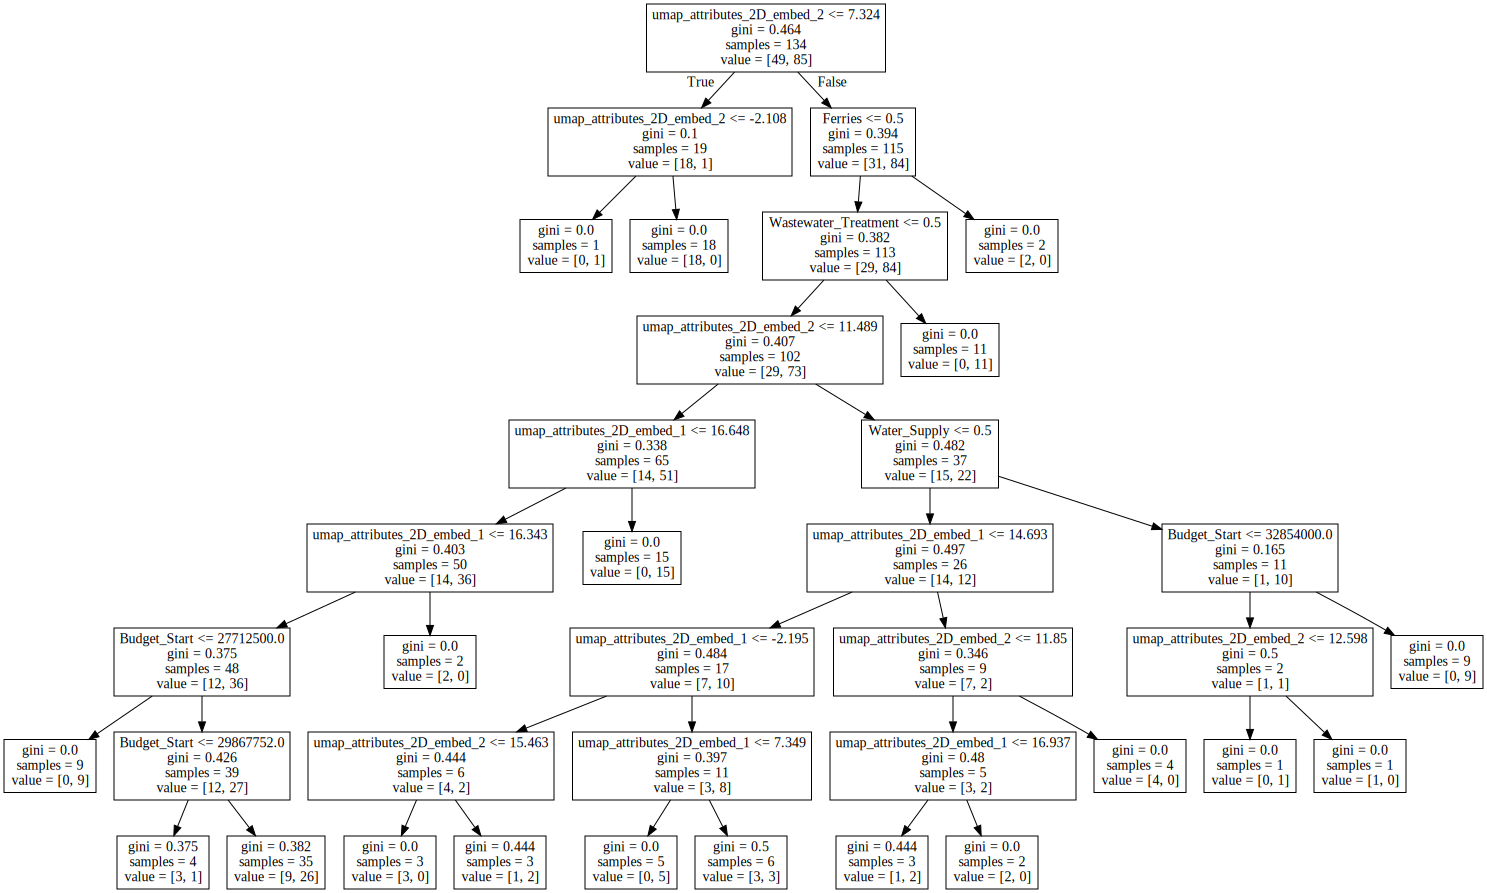

Model Optmized for: ['Schedule_Change_Ratio']


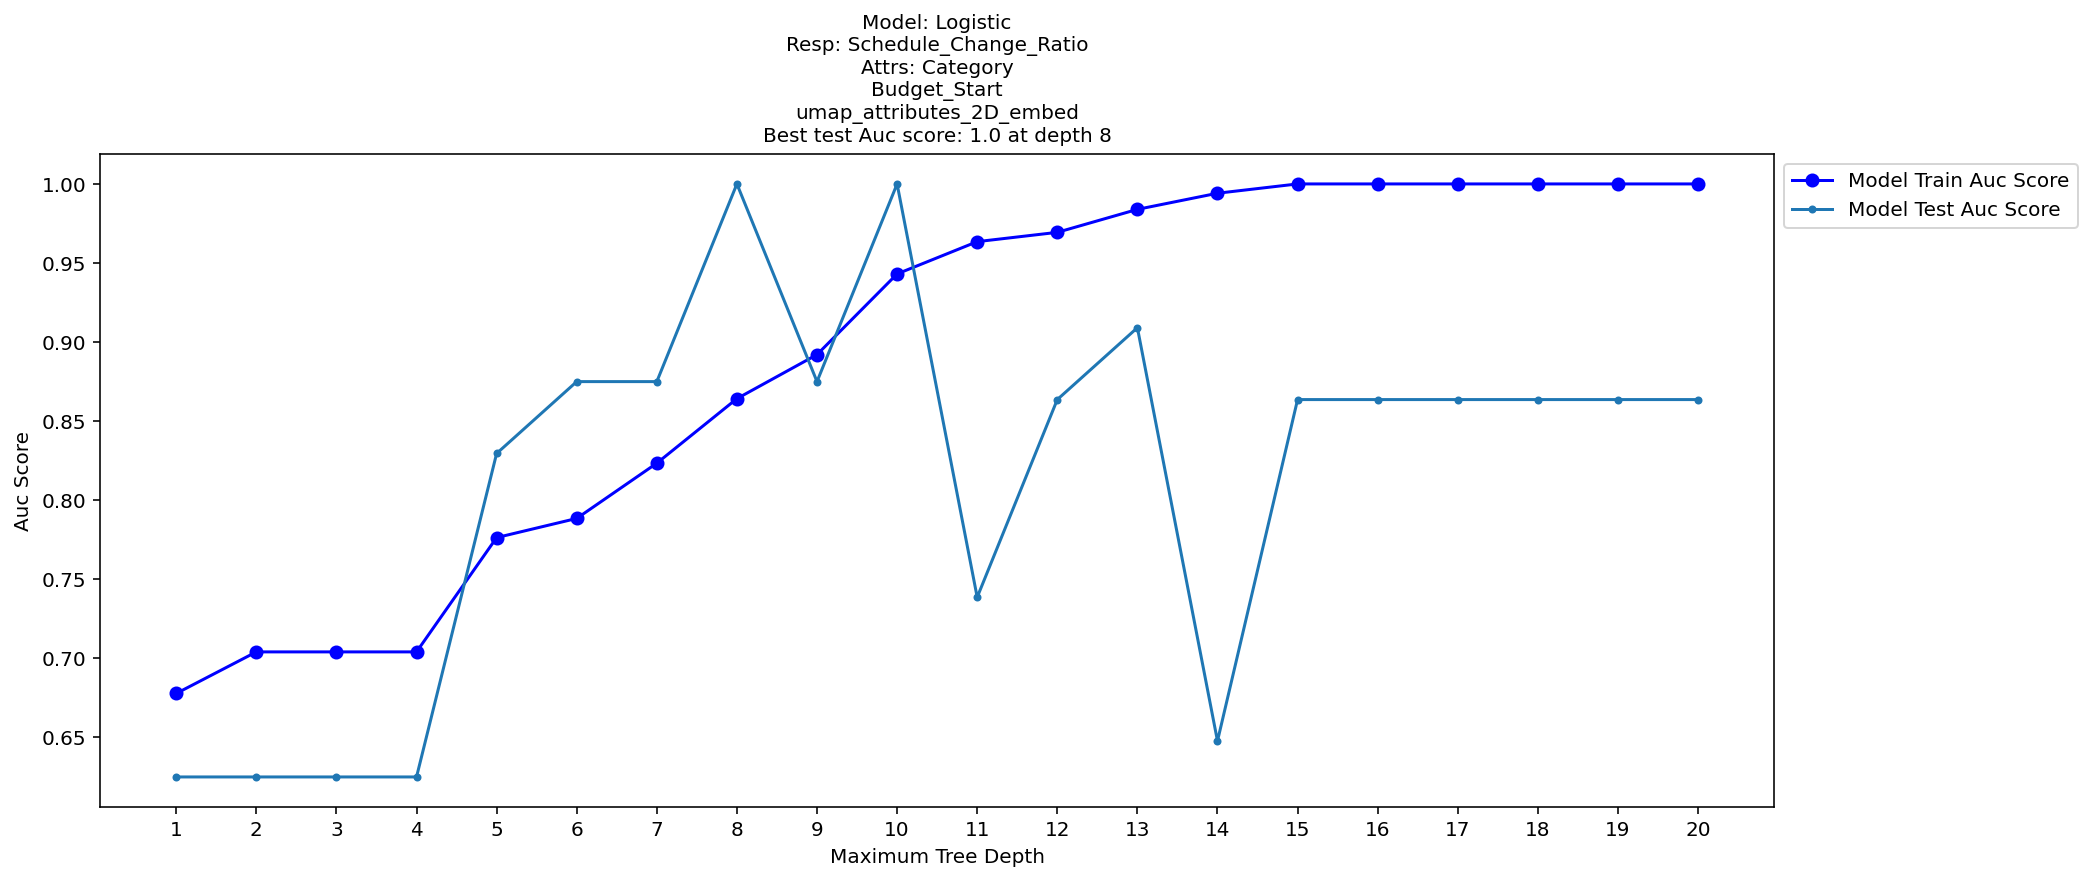

In [10]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

with open('../models/tree_classifier_schedule_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-classifier model predicting schedule_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

### Review Best Performing Model with 'Budget Change' Response


Index Chosen: 54
Best auc Score of Model Chosen: 0.75 // Depth: 11
Model Attributes: ['Category', 'umap_attributes_2D_embed', 'pca_descr_embed']
Model Response: ['Budget_Change_Ratio']


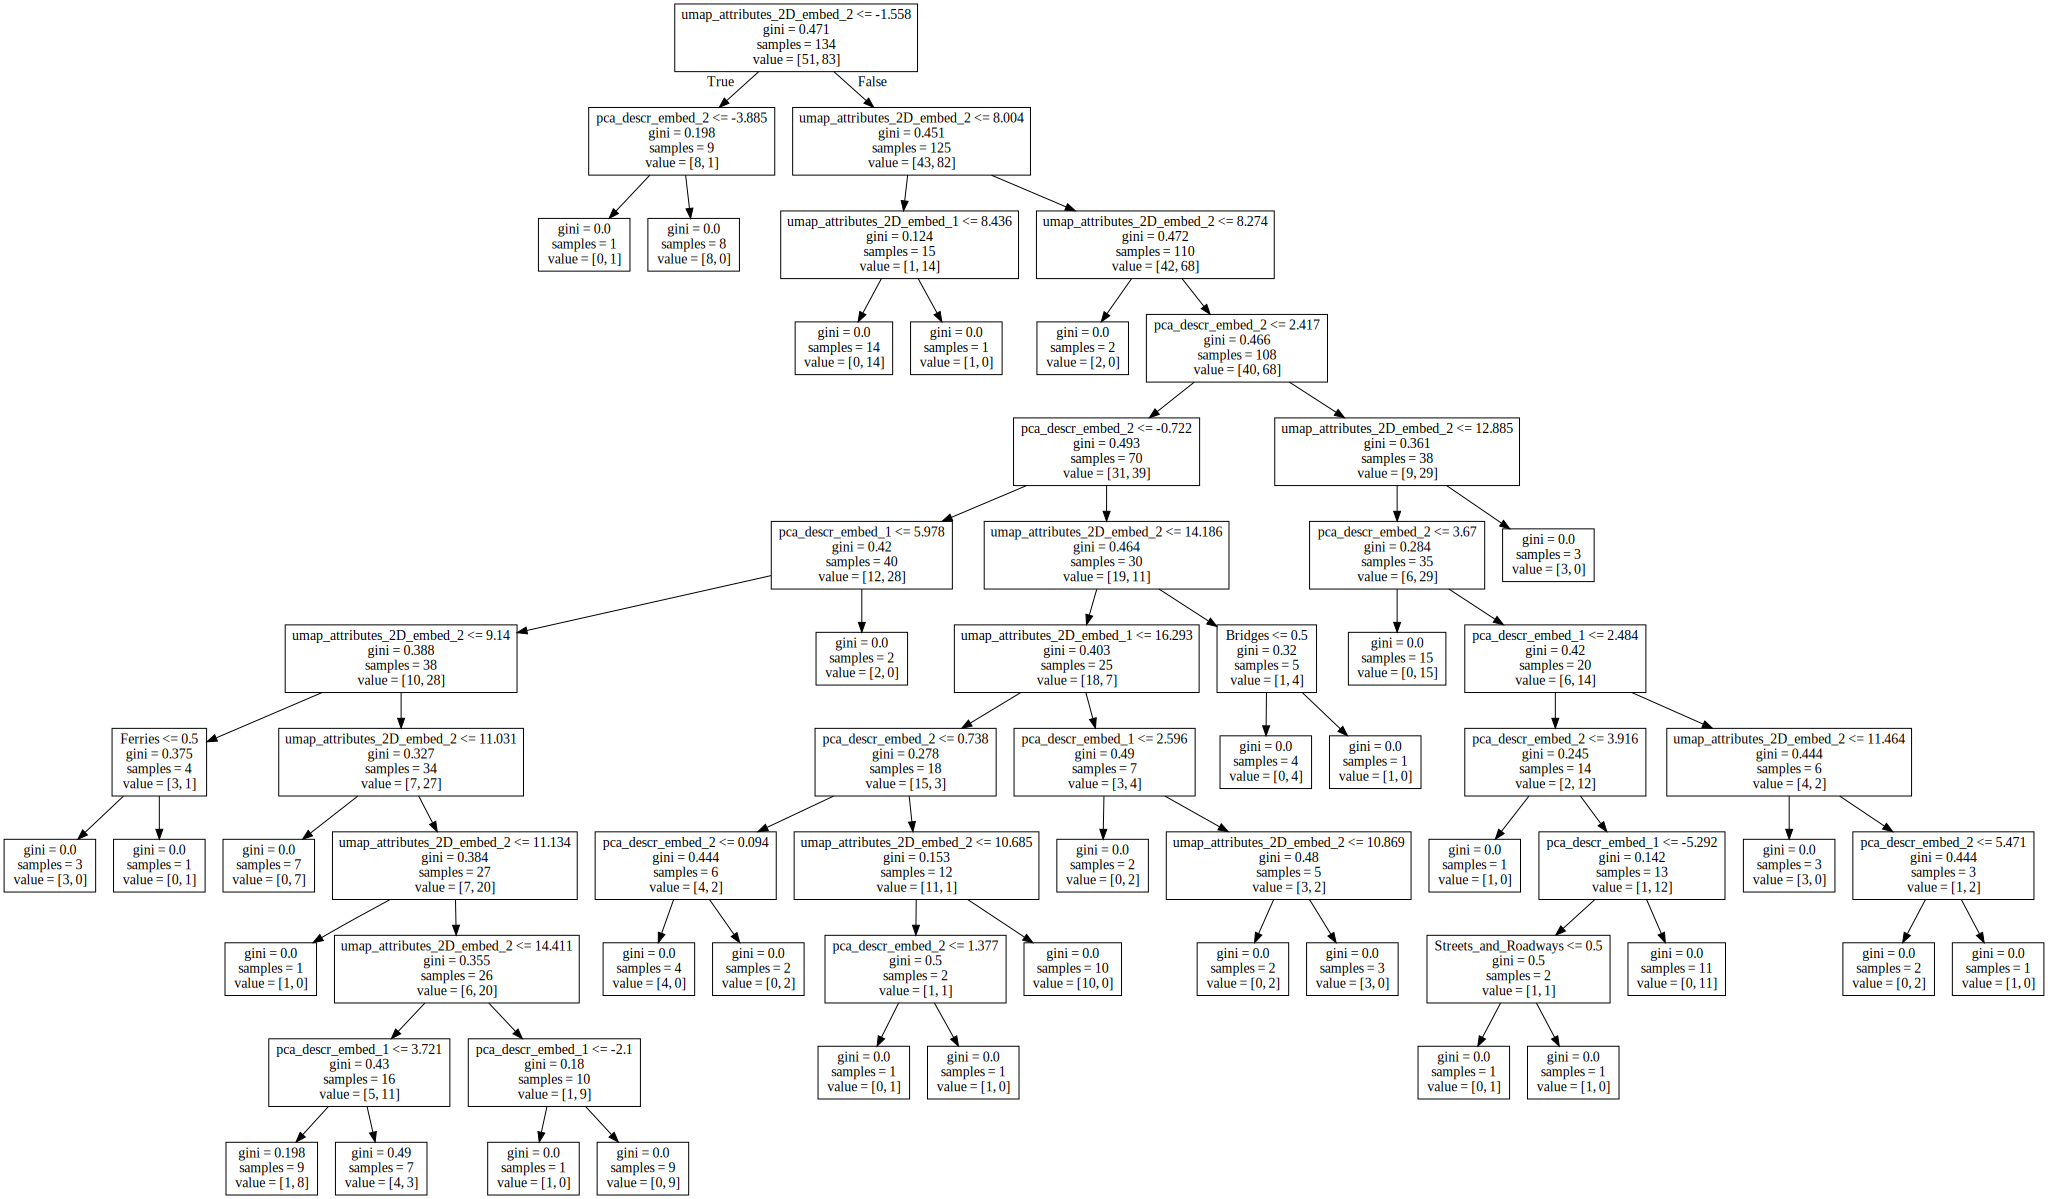

Model Optmized for: ['Budget_Change_Ratio']


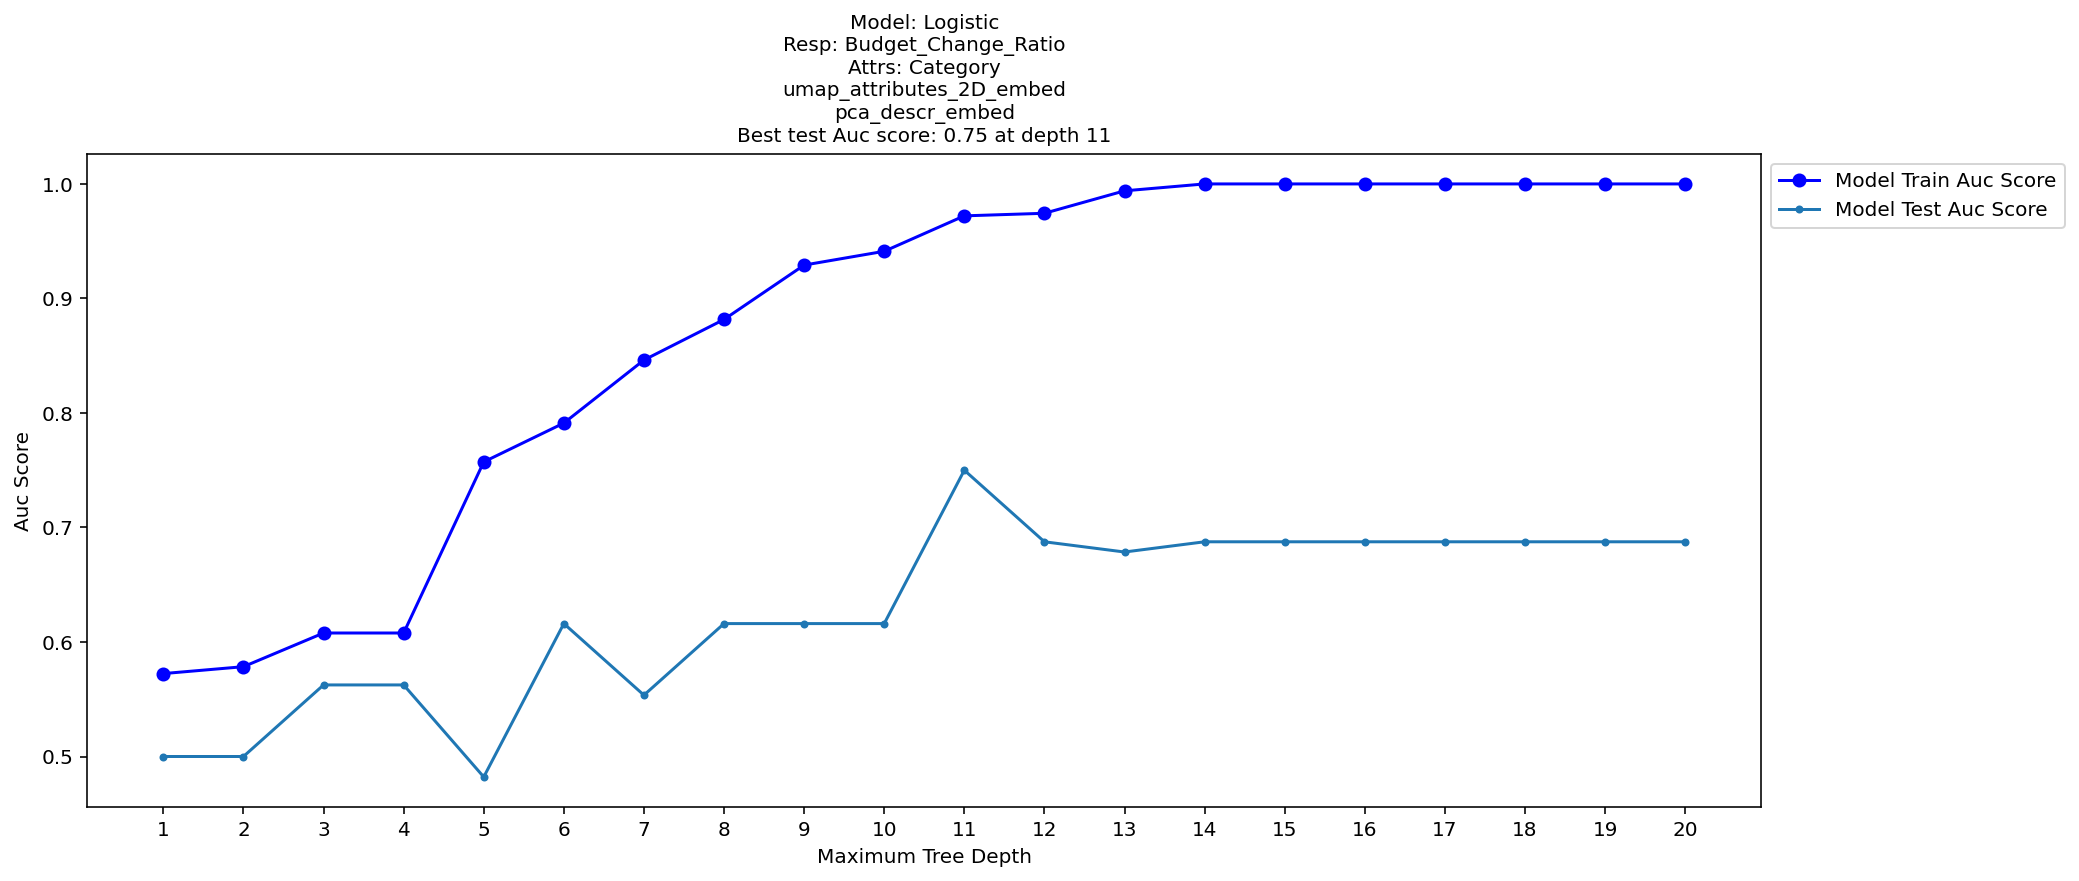

In [11]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

plot_me(results_all[idx])

with open('../models/tree_classifier_budget_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-classifier model predicting budget_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

### Classification models

These models will only try to predict if the budget or schedule will be over or under the initial estimate after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

#### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :

'Category', 'Budget_Start', 'umap_attributes_2D_embed'

Best depth: 8

Best AUC score: 1.0

Of note is that attributes using the project description embeddeding did not find the optimal model.
Also interestingis that the starting planned schedule is not used to find the outcome of the Schedule.

#### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :

'Category', 'umap_attributes_2D_embed', 'pca_descr_embed'

Best depth: 11

Best AUC score: 0.75

Here, the description is inidicative the budget outcome.  Worth noting is the in the starting budget value is not useful in finding the optimal model to predict the budget outcome.


# Fit decision tree regression models with various attribute combinations

[Return to top](#Notebook-contents)

The following steps will find the best combination of attributes to find the models which best predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` for each project.

In [12]:
%%time

nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
responses_list = [['Budget_Change_Ratio'], ['Schedule_Change_Ratio']] 

results_all, model_dicts = calc_models(nondescr_attrbutes, descr_attributes, responses_list, logistic=False)

Using REGRESSION models



CPU times: user 2min 20s, sys: 176 ms, total: 2min 20s
Wall time: 2min 20s


In [13]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False).head(3)

,desc,model_type,attributes,full_attributes,responses,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_and_Schedule_Change,scoring,best_depth,train_score,train_scores,test_score,test_scores,best_model,depths
77,Regression Tree. Depth: 4,Regression,"[Duration_Start, umap_attributes_2D_embed, ae_...","[Duration_Start, umap_attributes_2D_embed_1, u...",[Schedule_Change_Ratio],0,1,0,r2,4,0.77,"[0.44471966298379717, 0.523086226911782, 0.618...",0.72,"[0.3952918025270771, 0.4574362138790571, 0.538...","DecisionTreeRegressor(max_depth=4, random_stat...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
21,Regression Tree. Depth: 5,Regression,"[Duration_Start, ae_descr_embed]","[Duration_Start, ae_descr_embed_1, ae_descr_em...",[Schedule_Change_Ratio],0,1,0,r2,5,0.78,"[0.44471966298379717, 0.5213436120754693, 0.61...",0.71,"[0.3952918025270771, 0.45114950333778514, 0.53...","DecisionTreeRegressor(max_depth=5, random_stat...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
101,Regression Tree. Depth: 4,Regression,"[Category, Duration_Start, umap_attributes_2D_...","[Duration_Start, Bridges, Ferries, Industrial_...",[Schedule_Change_Ratio],0,1,0,r2,4,0.77,"[0.44471966298379717, 0.523086226911782, 0.618...",0.71,"[0.3952918025270771, 0.4574362138790572, 0.538...","DecisionTreeRegressor(max_depth=4, random_stat...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 77
Model Optmized for: ['Schedule_Change_Ratio']
Best r2 Score of Model Chosen: 0.7239 // Depth: 4
Model Attributes: ['Duration_Start', 'umap_attributes_2D_embed', 'ae_descr_embed']
Model Response: ['Schedule_Change_Ratio']


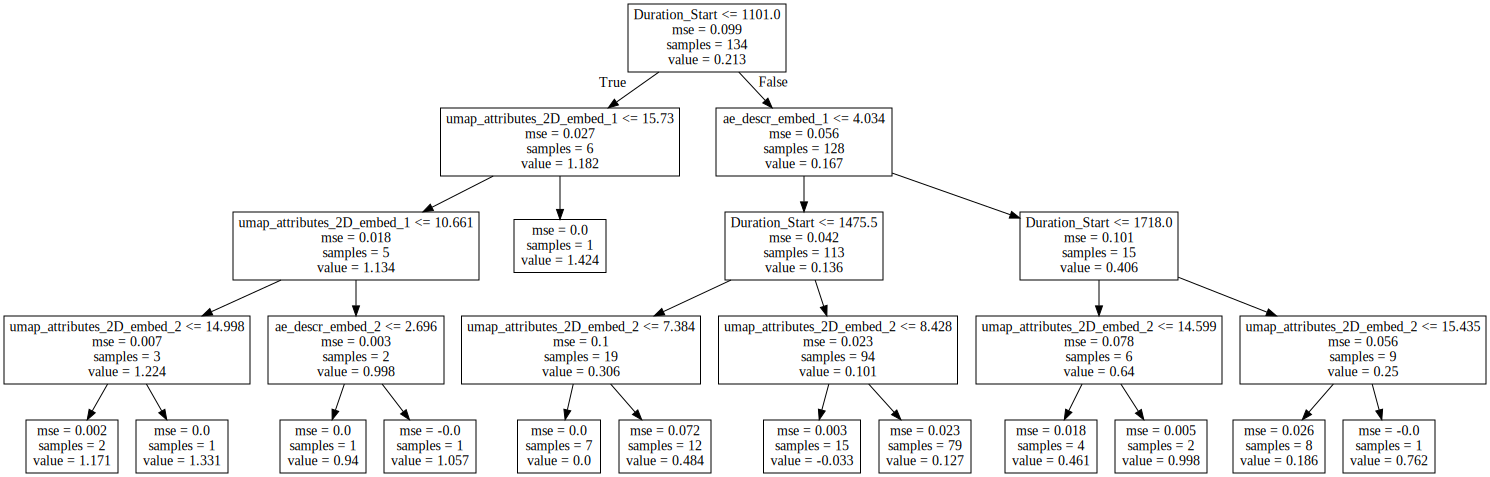


MODEL SUMMARY:
Regression Tree. Depth: 4


The fitted model object(s):

	DecisionTreeRegressor(max_depth=4, random_state=109)

	DecisionTreeRegressor(max_depth=4, random_state=109)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9905
		Test		-0.0037

	Schedule_Change_Ratio

		Training	0.7744
		Test		0.7239





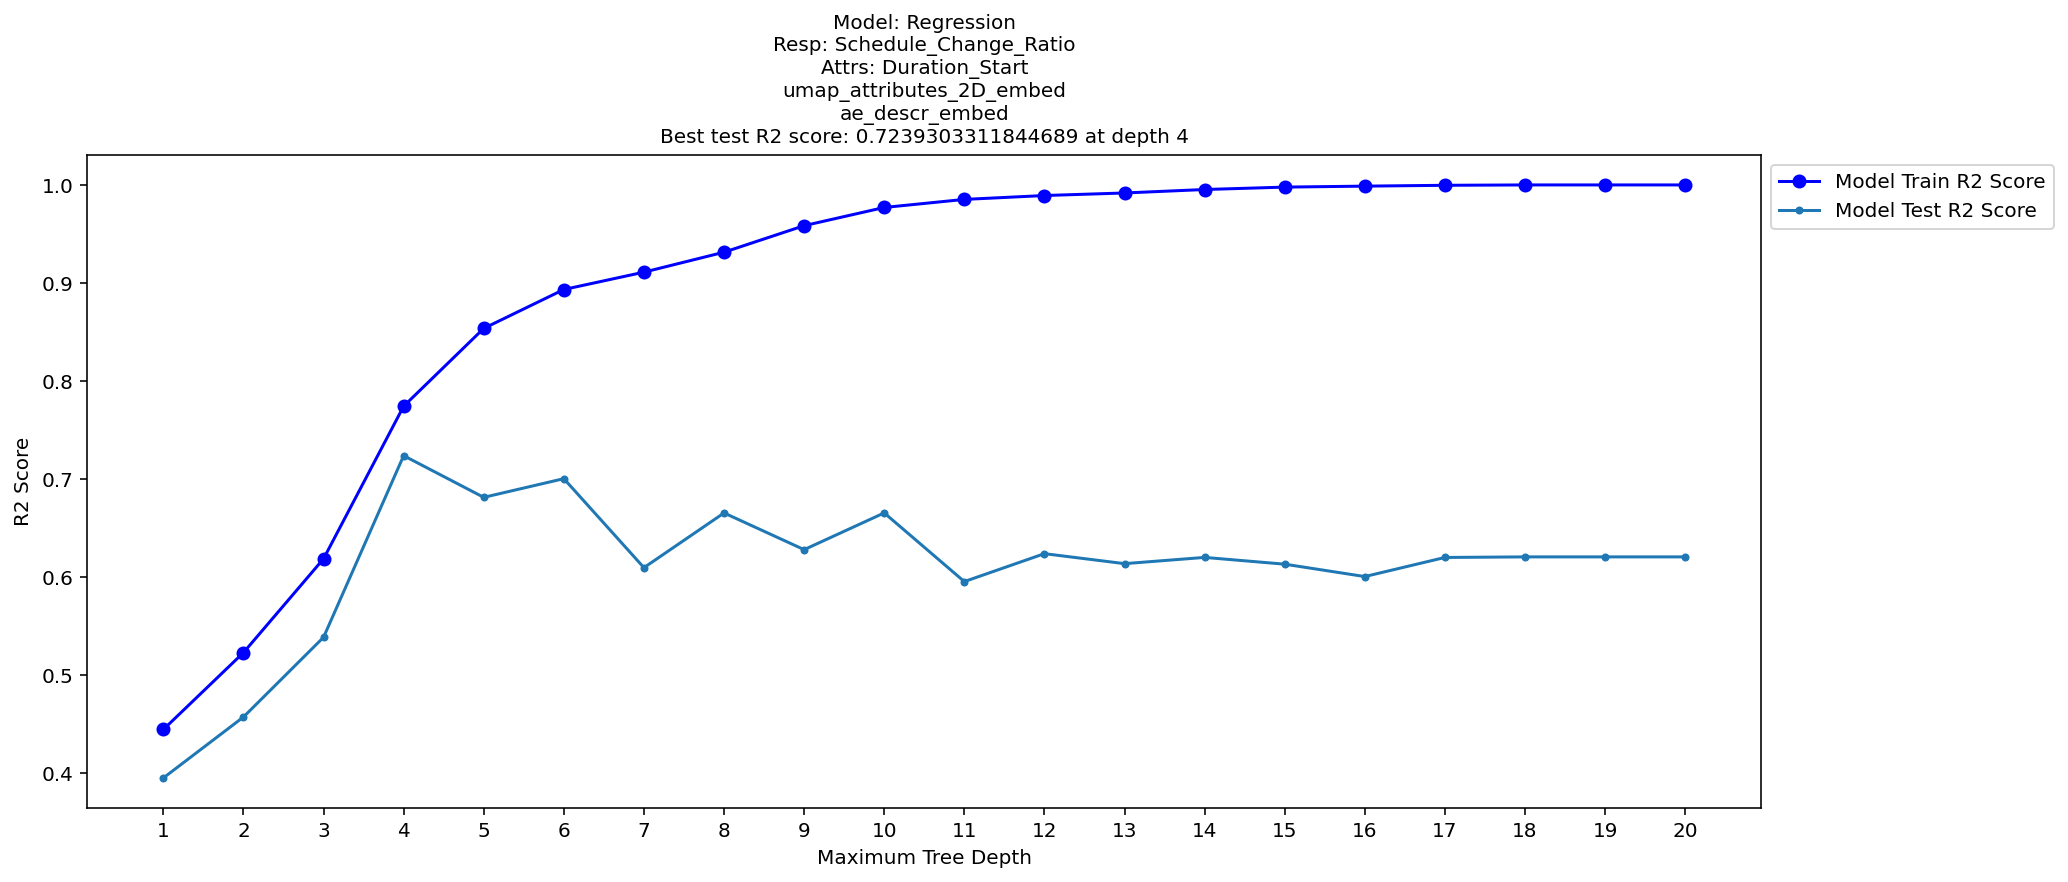

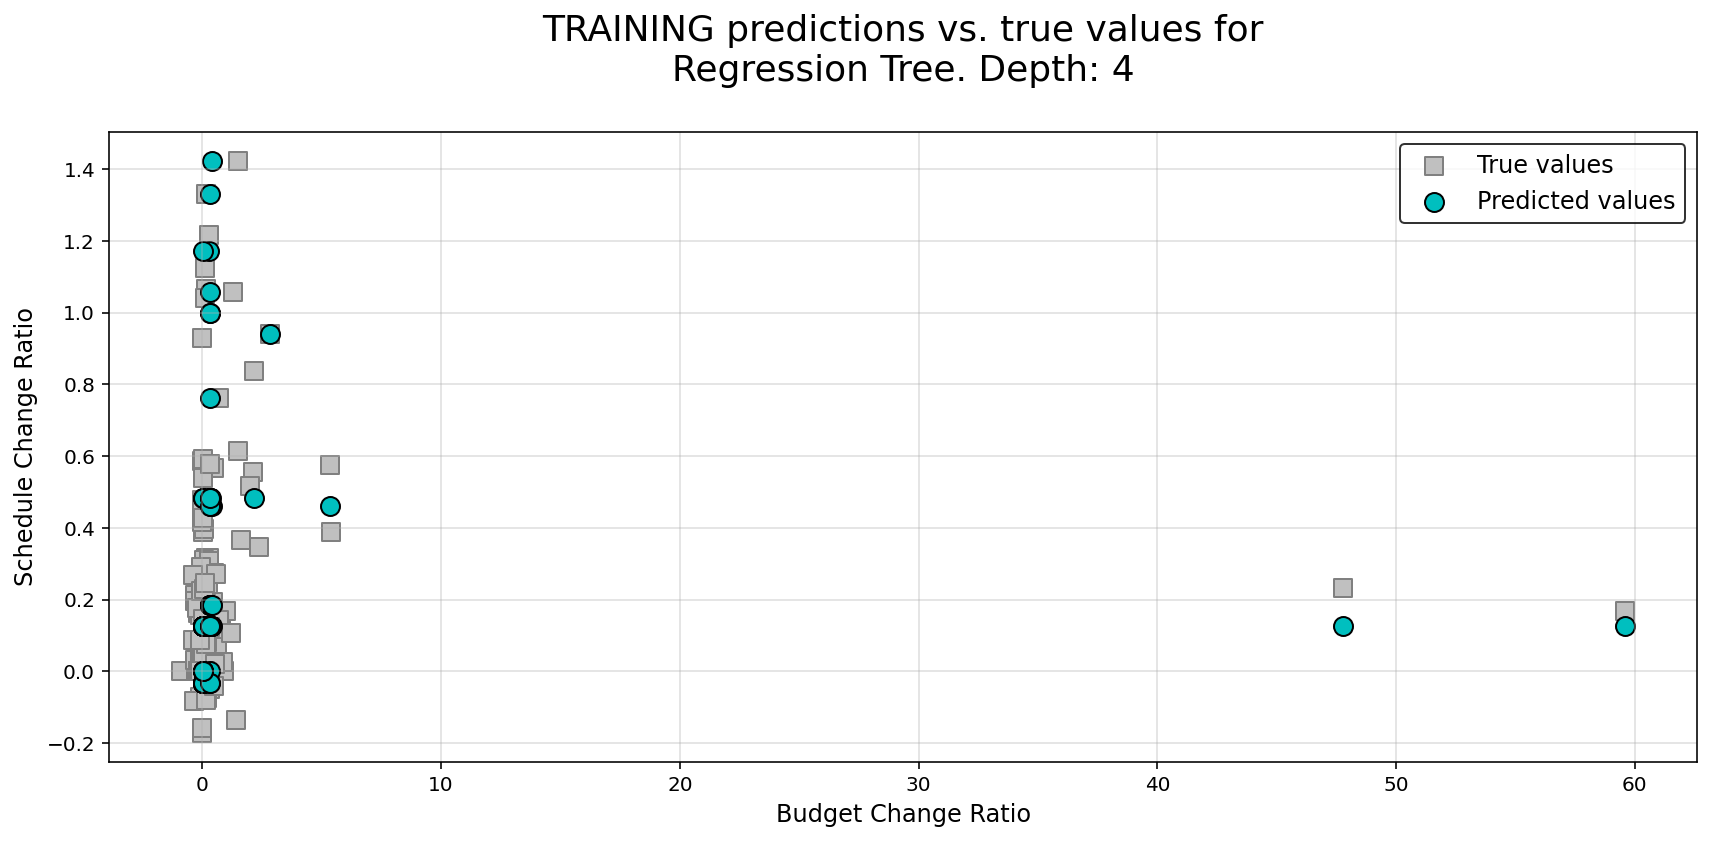

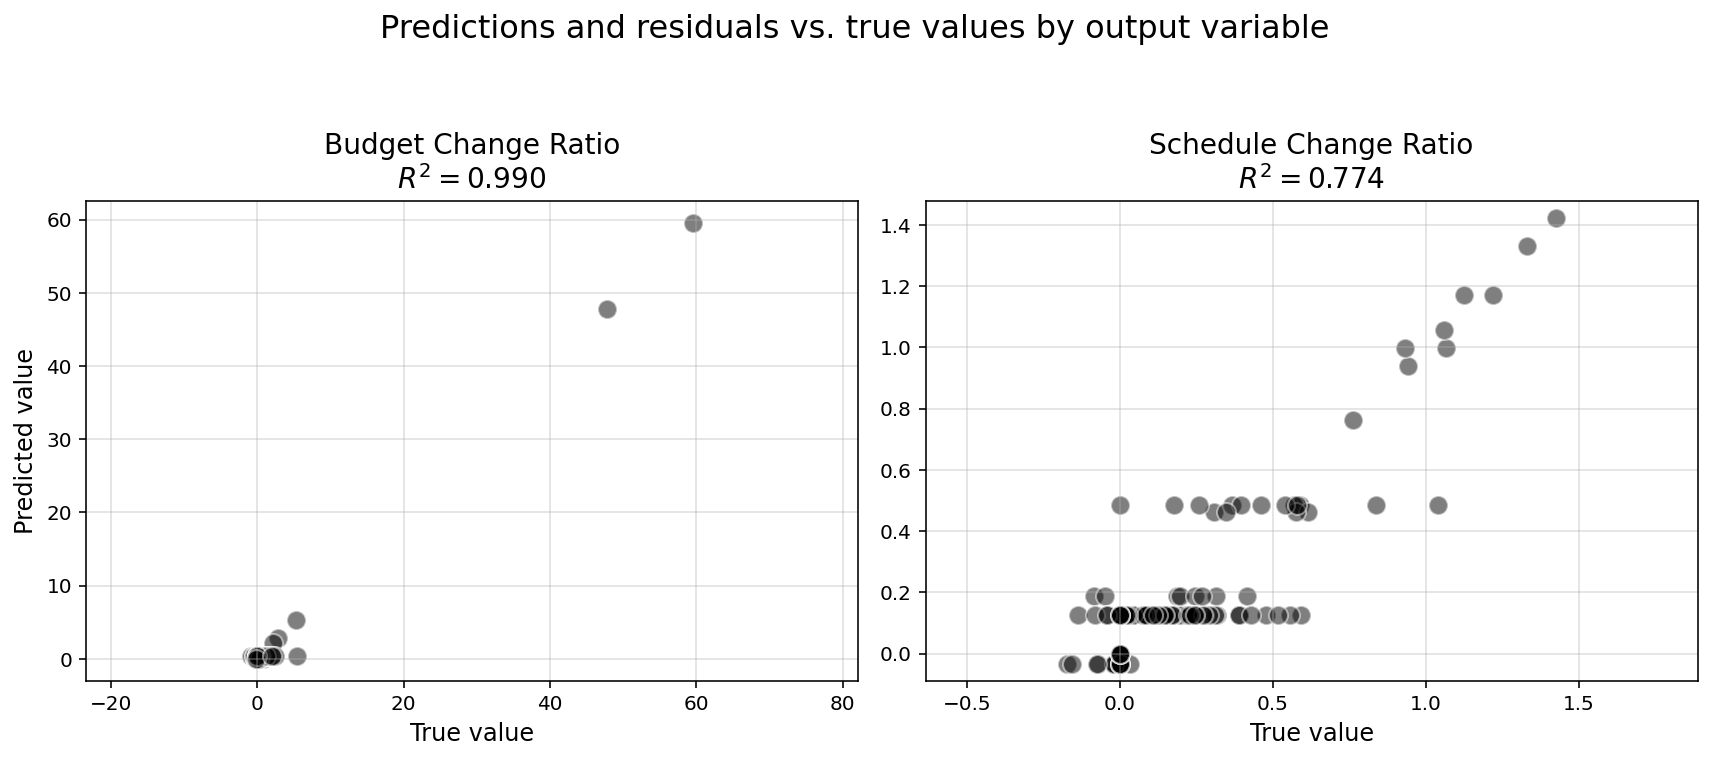

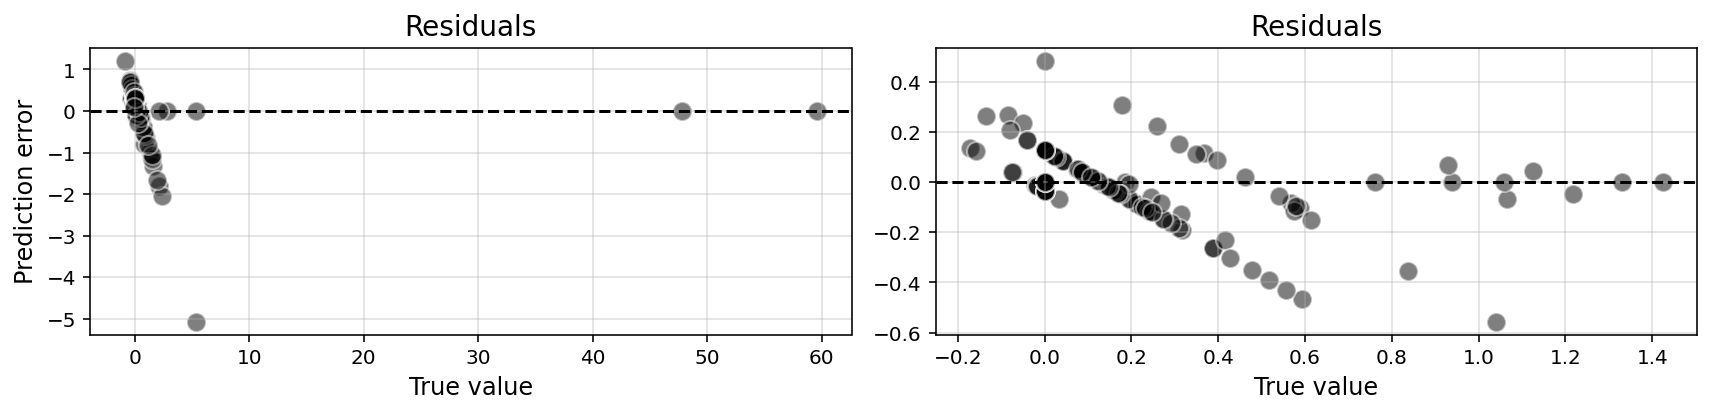

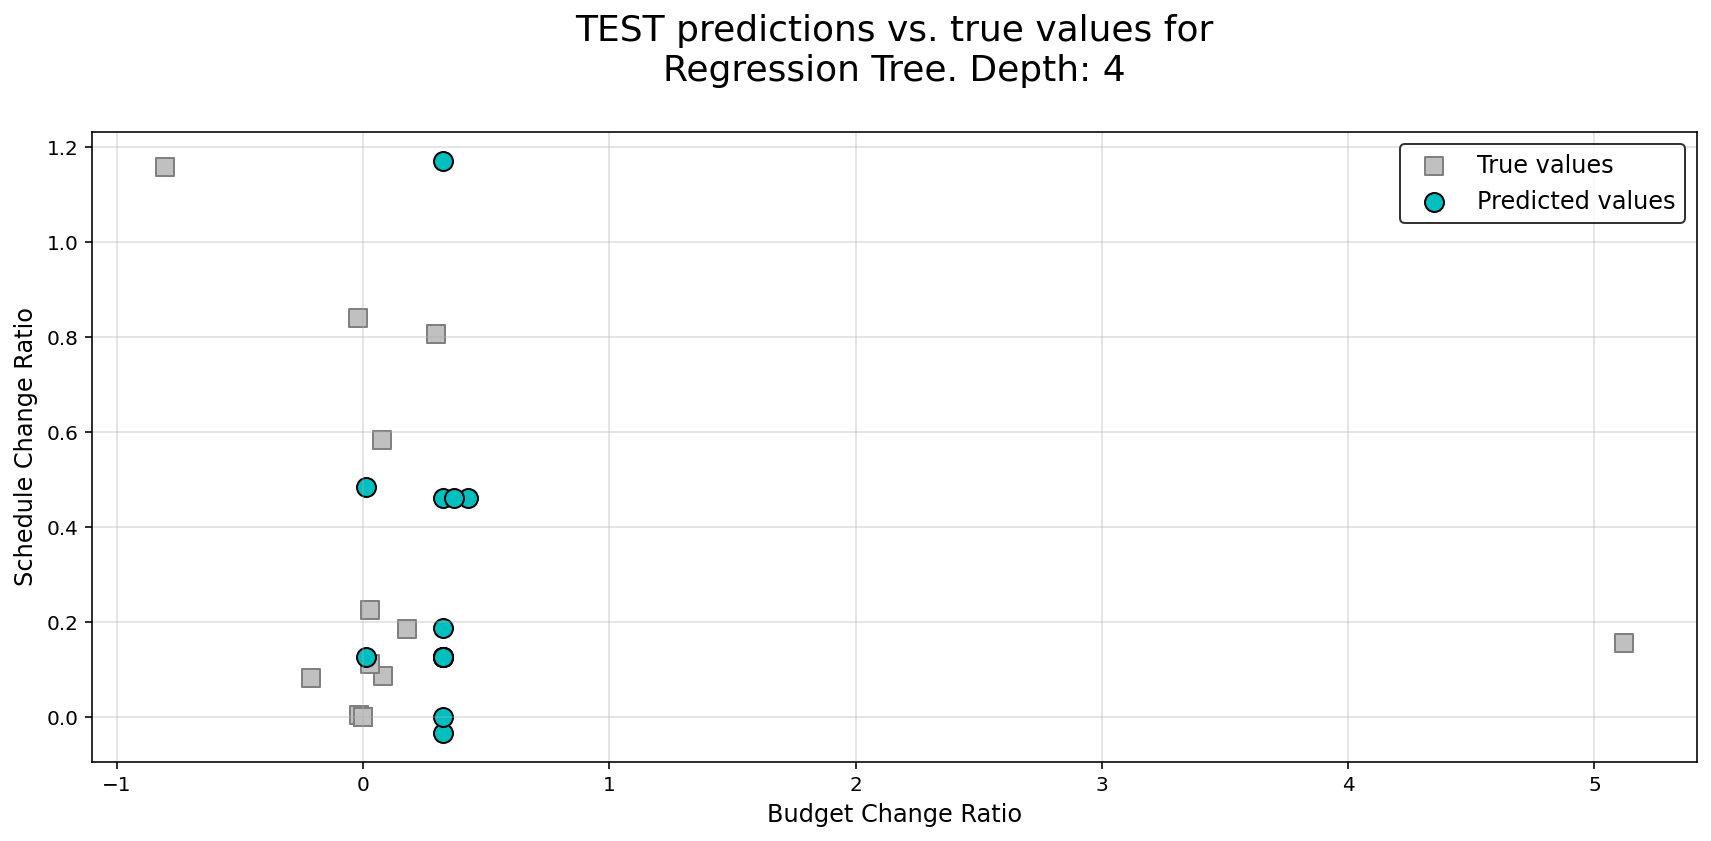

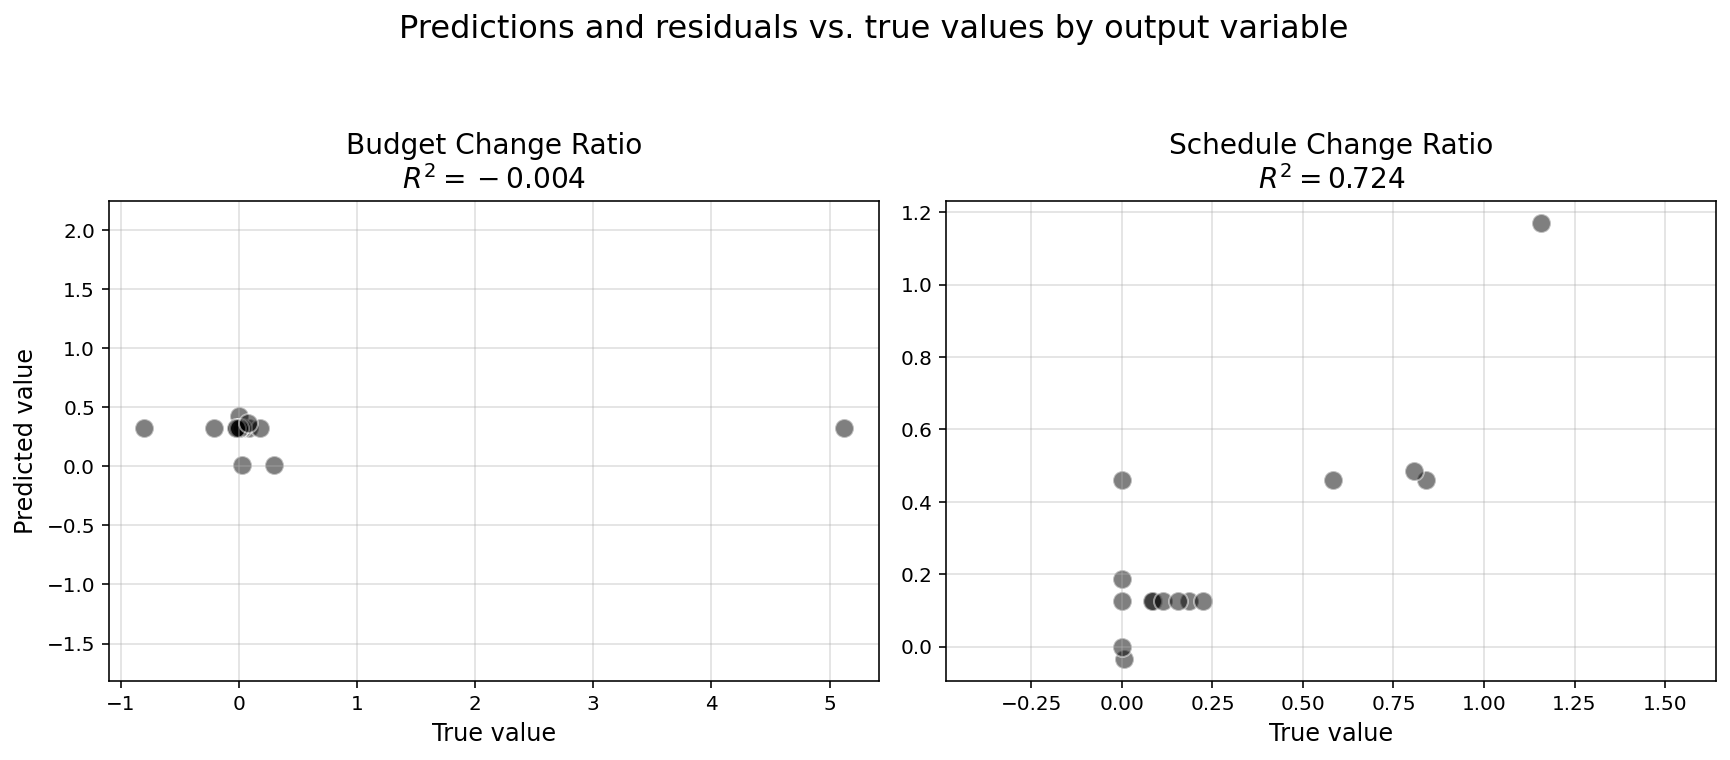

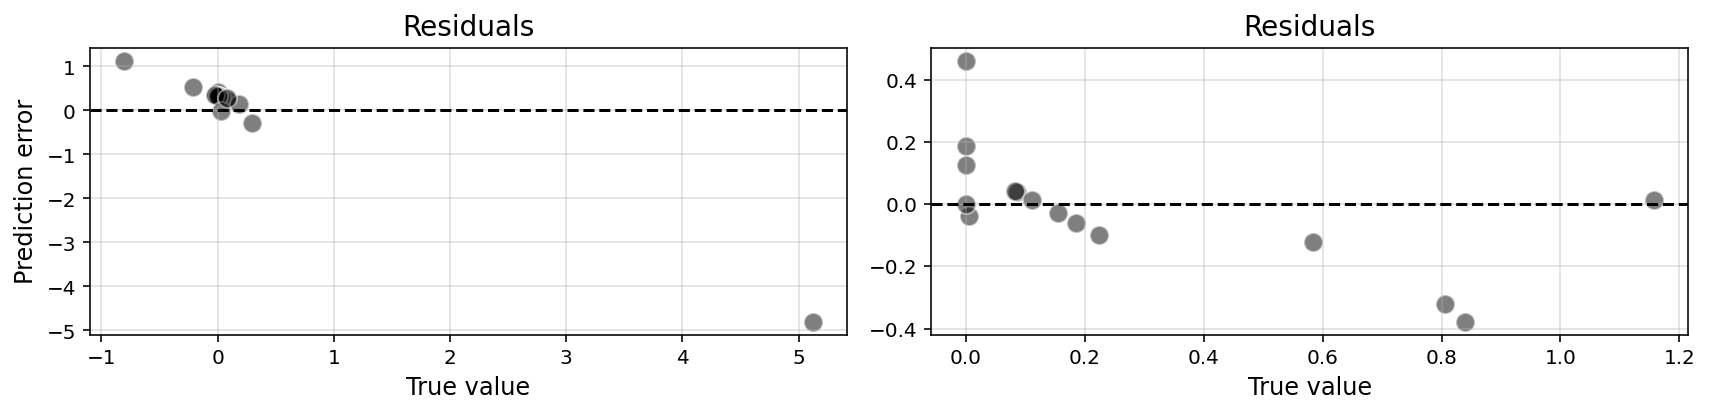

In [14]:
resp = 'Schedule_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

with open('../models/tree_regressor_schedule_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-regressor model predicting schedule_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

Index Chosen: 12
Model Optmized for: ['Budget_Change_Ratio']
Best r2 Score of Model Chosen: 0.419 // Depth: 9
Model Attributes: ['Budget_Start', 'ae_descr_embed']
Model Response: ['Budget_Change_Ratio']


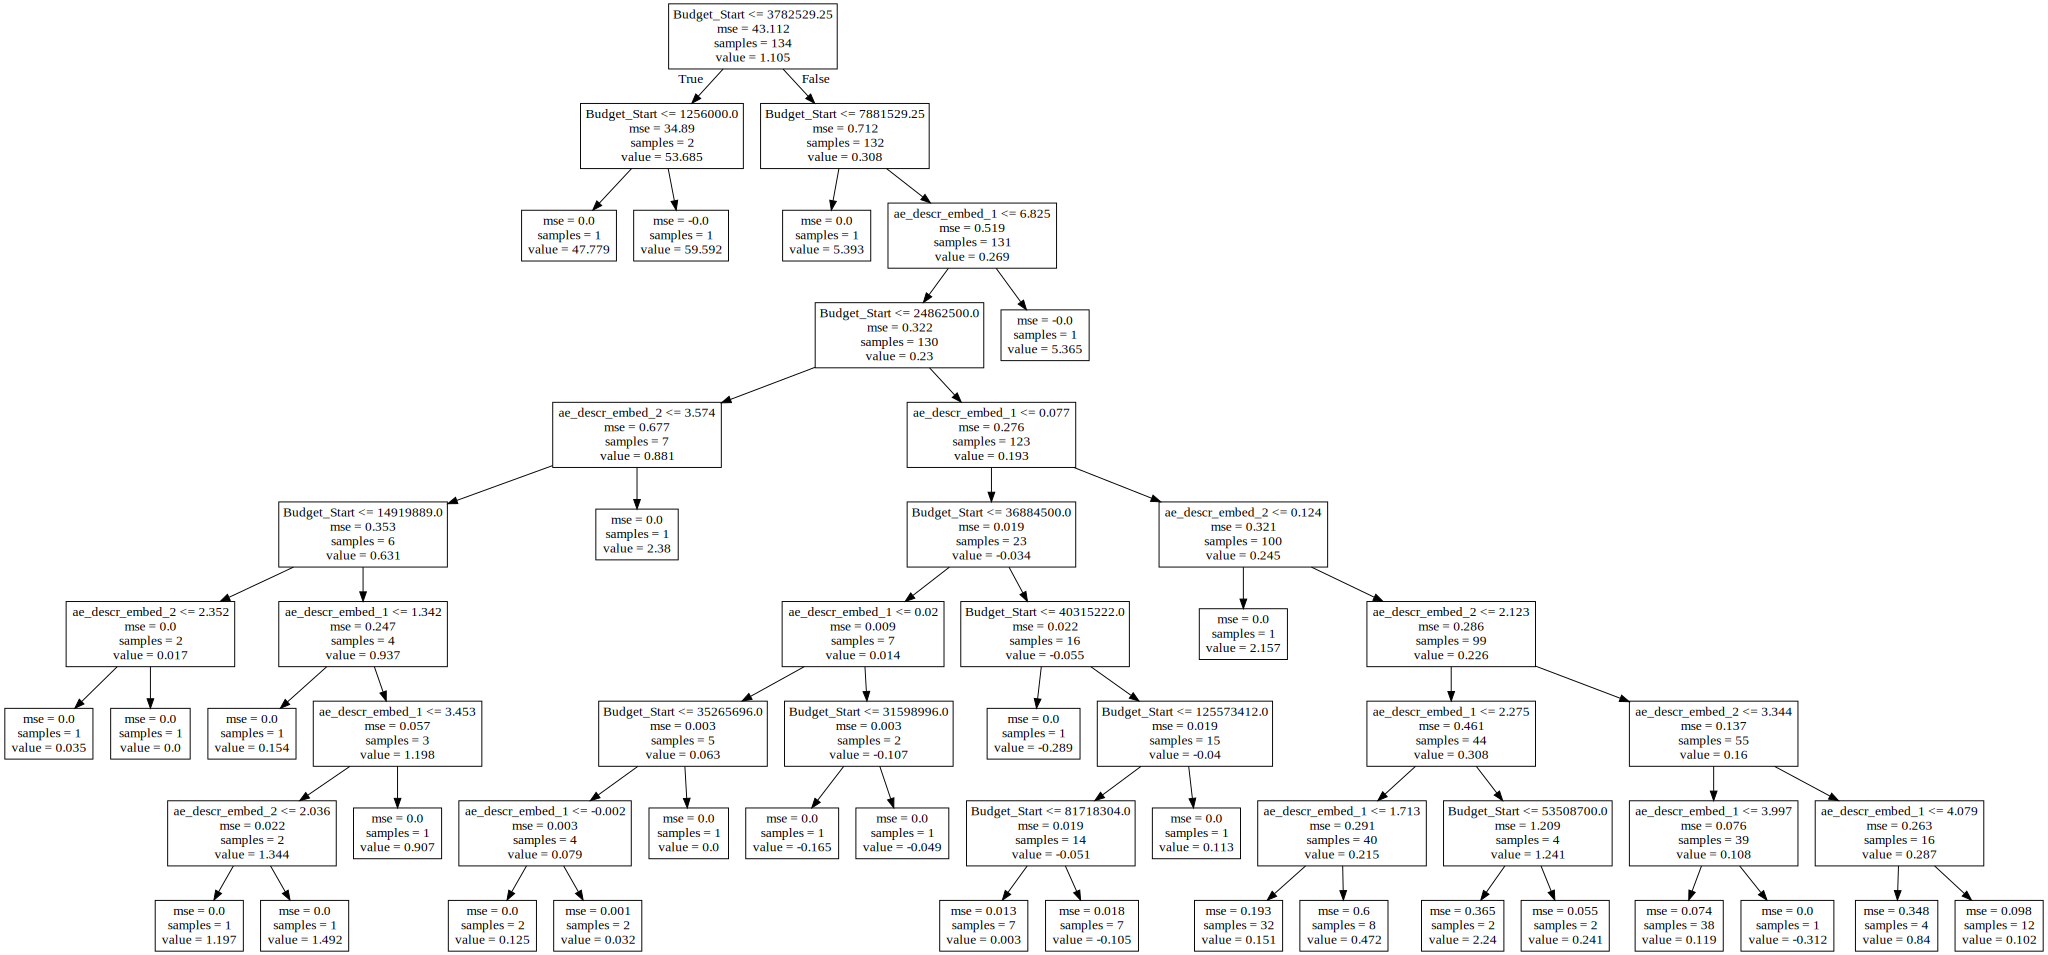


MODEL SUMMARY:
Regression Tree. Depth: 9


The fitted model object(s):

	DecisionTreeRegressor(max_depth=9, random_state=109)

	DecisionTreeRegressor(max_depth=9, random_state=109)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.9970
		Test		0.4190

	Schedule_Change_Ratio

		Training	0.8465
		Test		-0.1248





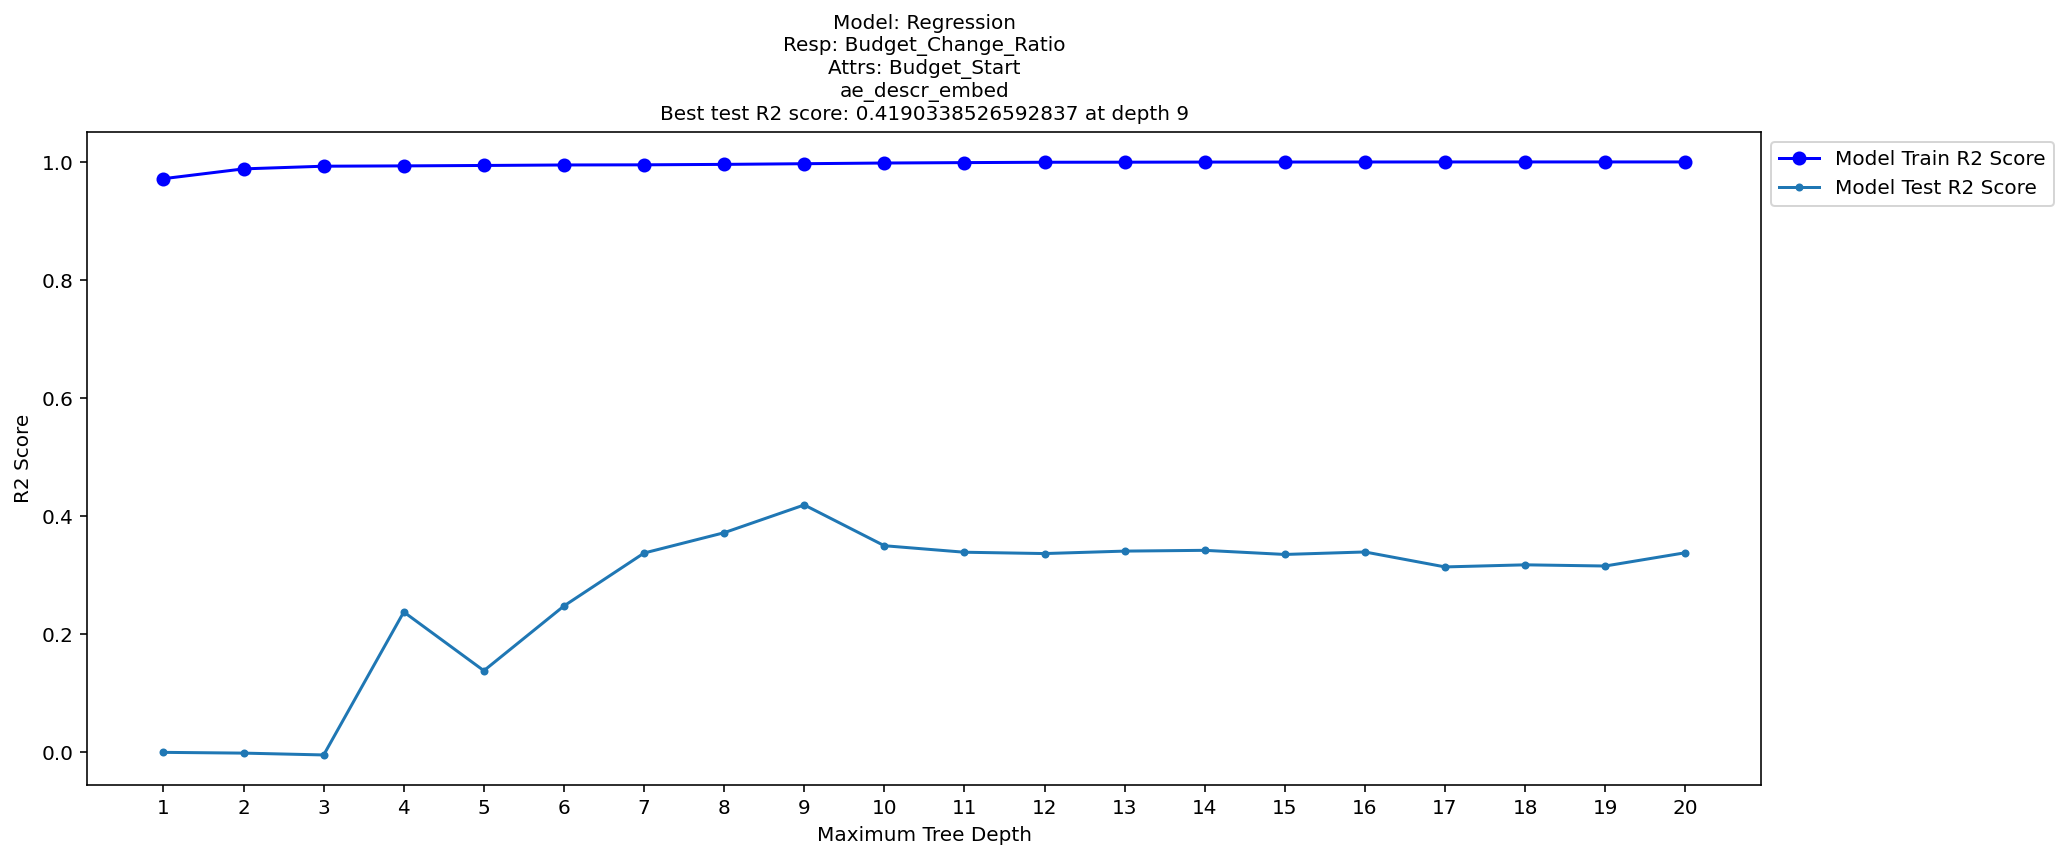

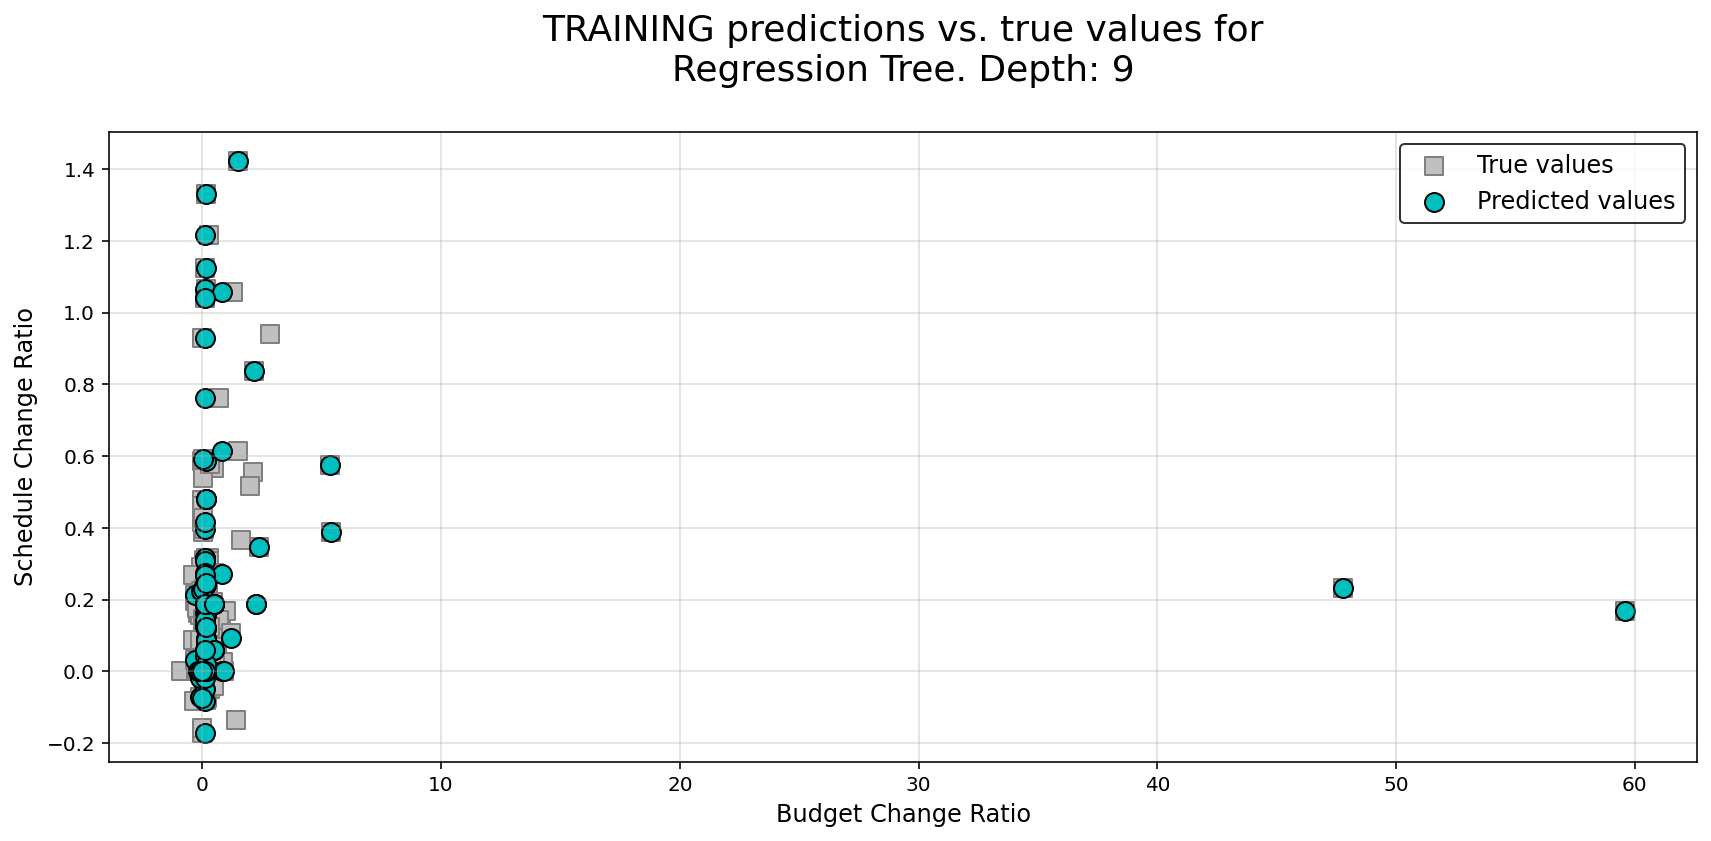

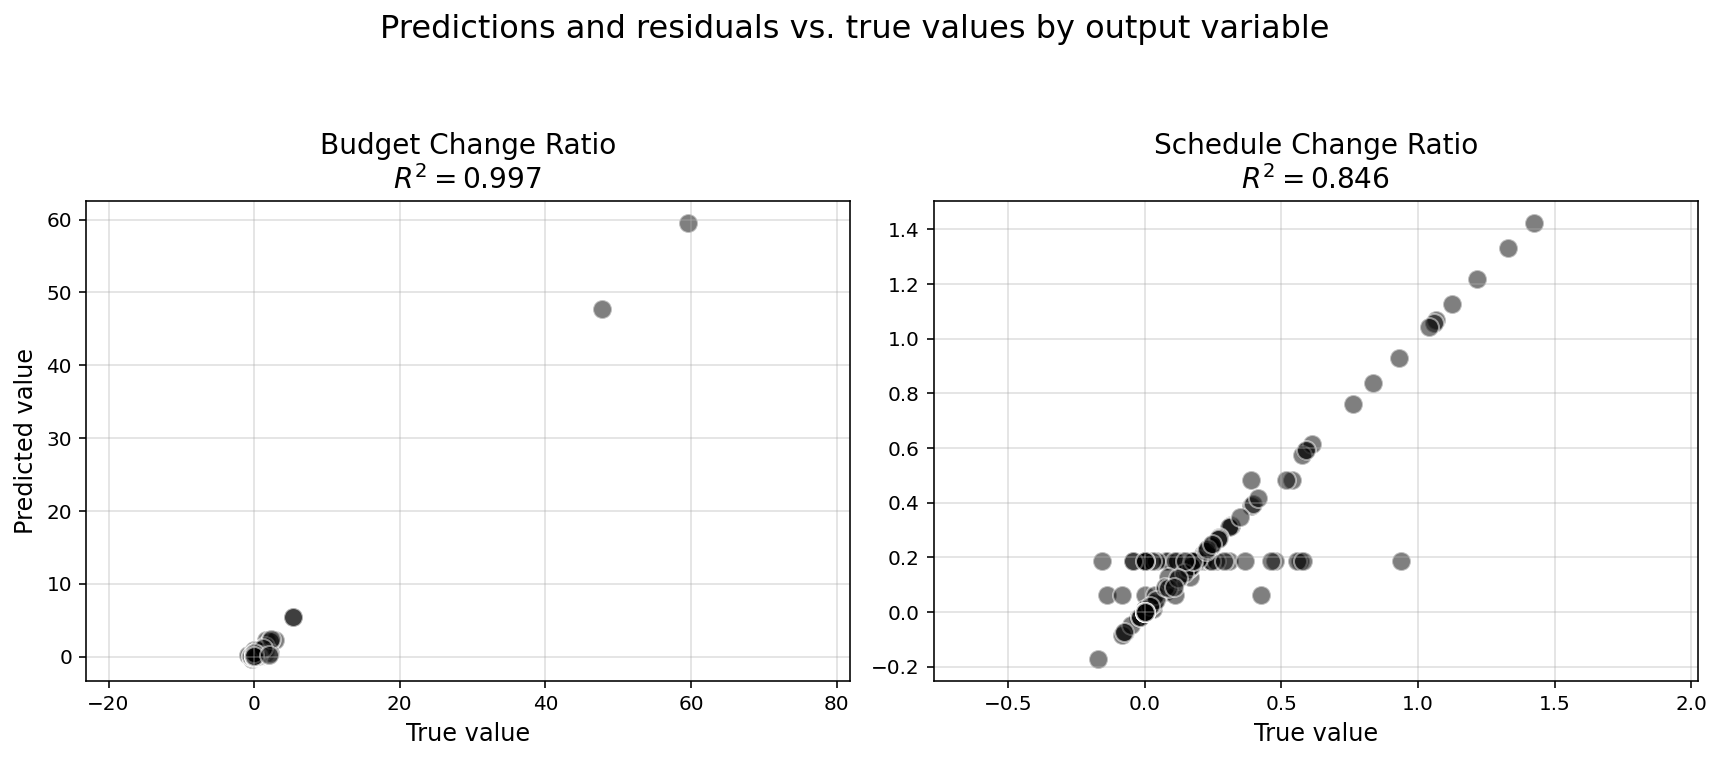

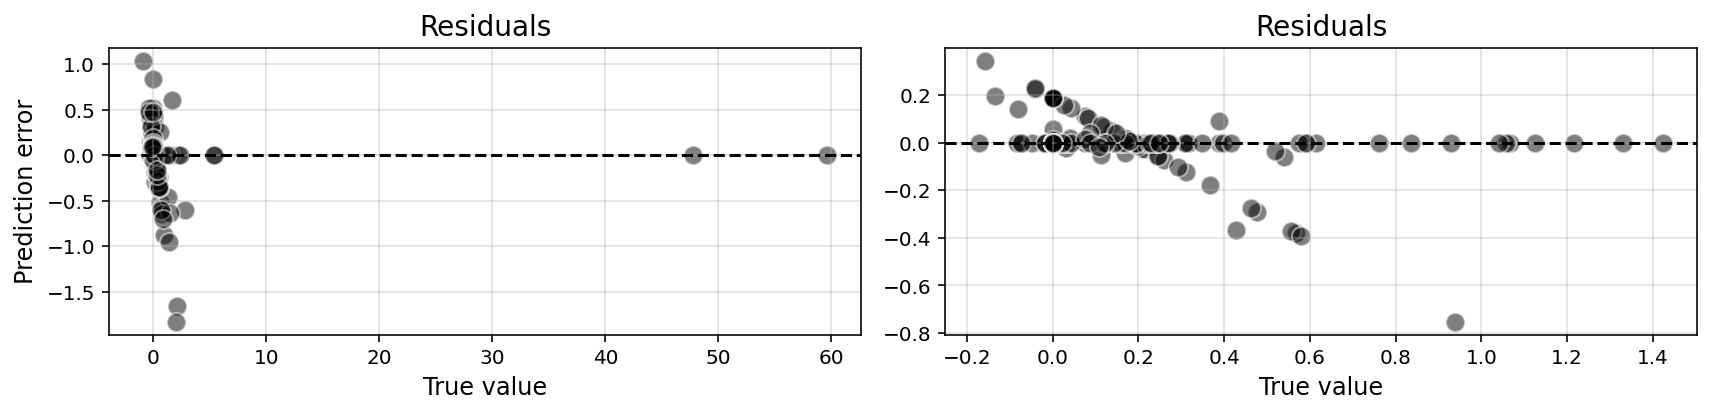

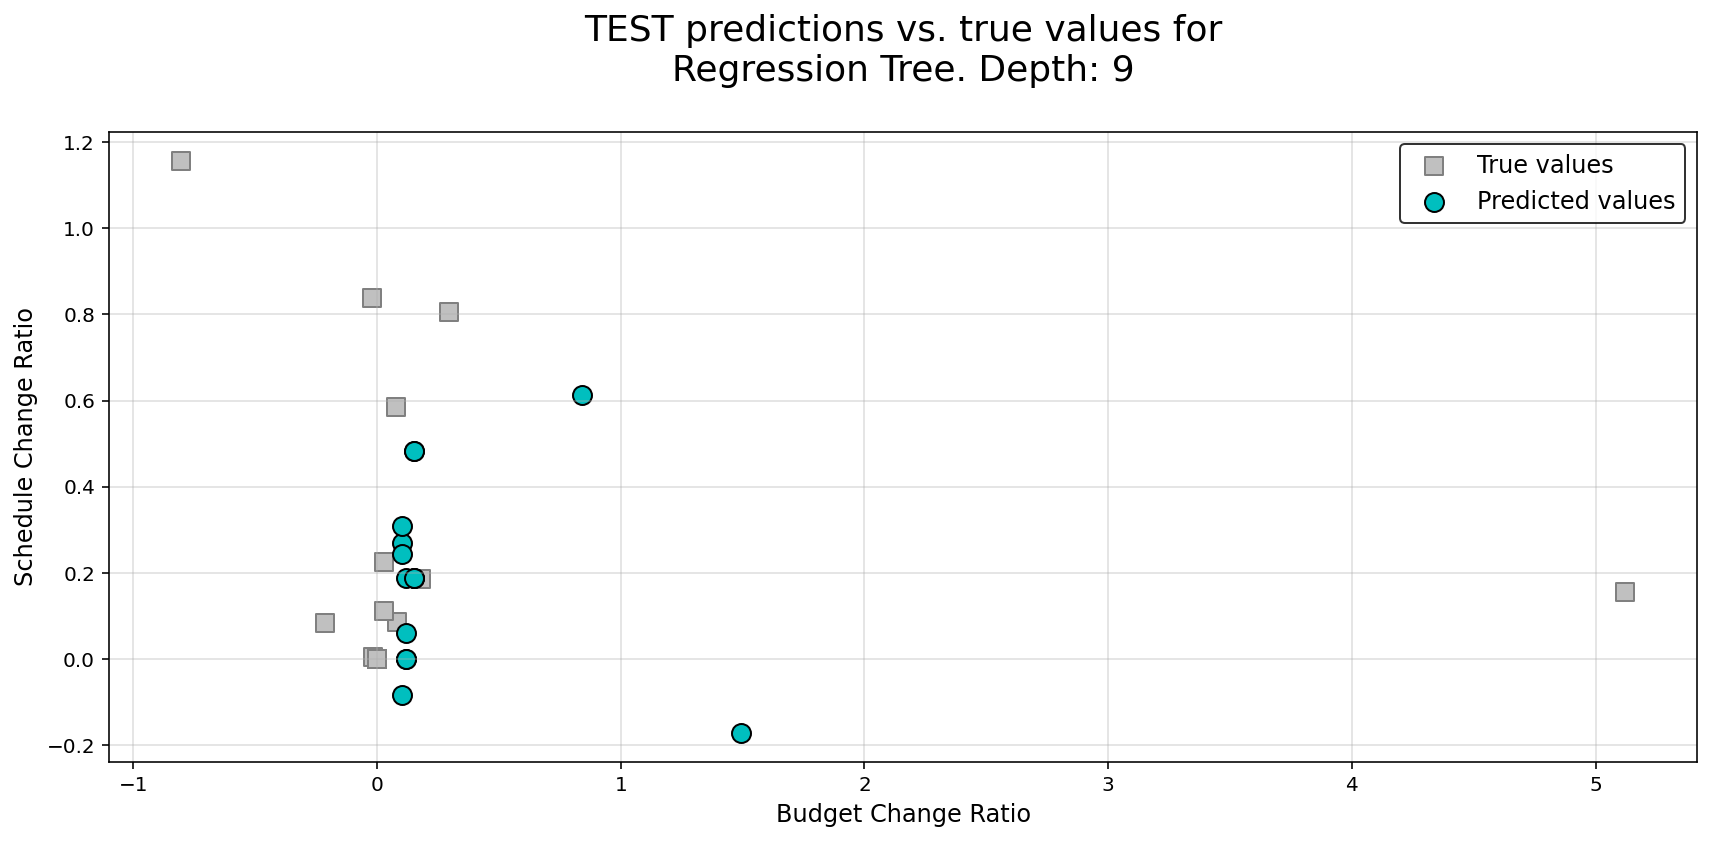

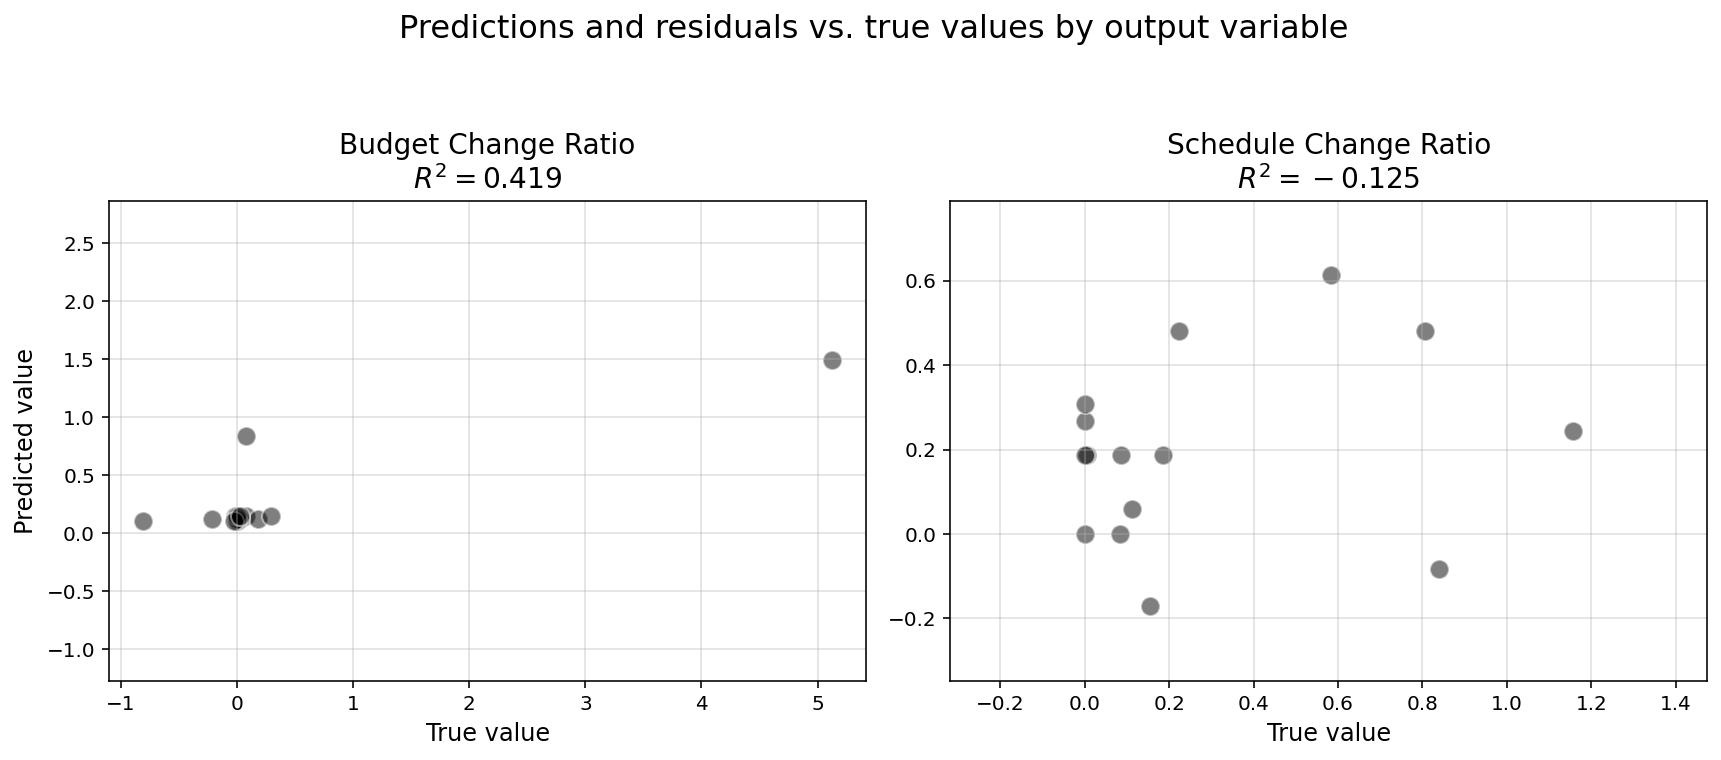

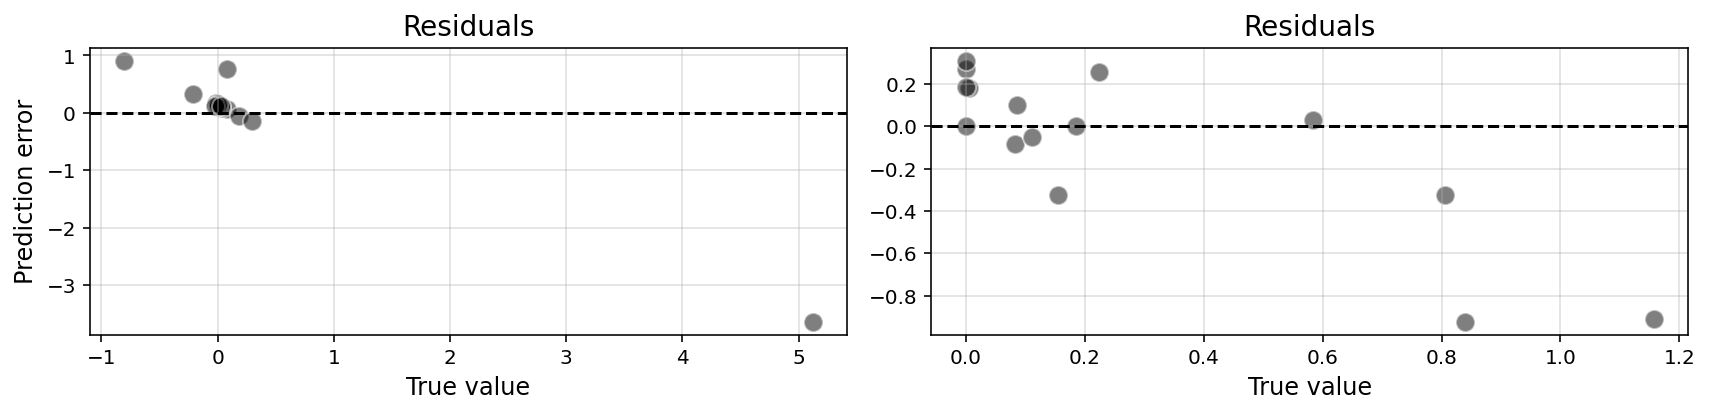

In [15]:
resp = 'Budget_Change_Ratio'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='test_score').iloc[0].name
score_type = results_df.iloc[idx].scoring
print(f"Index Chosen: {idx}")

m_dict = results_all[idx]

plot_me(results_all[idx])

print(f"Best {score_type} Score of Model Chosen: {round(max_score,4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict['best_model'], feature_names=m_dict['full_attributes'])
gr = graphviz.Source(tree_dot_data)
display(gr)

m = model_dicts[idx]
print_model_results(m)
plot_true_pred(m, dataset='train')
plot_true_pred(m, dataset='test')

with open('../models/tree_regressor_budget_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best tree-regressor model predicting budget_change_ratio',
                    'model': m_dict['best_model'],
                    'attributes': m_dict['full_attributes'],
                    'responses': m_dict['responses']
                }, fp)

### Regression models
These models attempt to predict the ending Schedule and Budget values after a 3-year period.

As expected, the optimal models for predicting 'Schedule' and 'Budget' are different.  
Both models produce trees with a depth of significant complexity.

#### The optimal 'Schedule' model uses the following parameters to predict 'Schedule Change Ratio :

Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed'

Best depth: 7

Best $R^2$ score: 0.7077

Of note is that attributes using the project description embeddeding did not find the optimal model.

#### The optimal 'Budget' model uses the following parameters to predict 'Budget Change Ratio :

'Budget_Start'

Best depth: 6

Best $R^2$ score: .3588

Here, only the starting budget value is determined to be significant when predicting 'Budget Change Ratio'.  The $R^2$ score is not exceptionally impressive which may be the result of some extreme outliers in the data.
